In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import safetensors.torch
import scipy.stats
import seaborn as sns
import torch
from torch import tensor, Tensor
import transformers
from typing import Callable, Iterable

import weight_formats.quantisation as Q
import weight_formats.experiments as E

transformers.utils.logging.disable_progress_bar()
matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load models

In [2]:
model = E.RequantisableModel.load("meta-llama/Llama-3.2-1B", torch.device("cpu"), dtype=torch.bfloat16)
tokenizer = transformers.AutoTokenizer.from_pretrained(model.model.config._name_or_path)
fisher = safetensors.torch.load_file("out/20250604-fisher/meta-llama--Llama-3.2-1B.safetensors")
params = {k: v.detach() for k, v in model.model.named_parameters()}

`torch_dtype` is deprecated! Use `dtype` instead!


In [3]:
out = model.model.generate(**tokenizer("The meaning of life is", return_tensors="pt"), max_new_tokens=20)
print(tokenizer.decode(out[0]))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>The meaning of life is to find your dream job and be happy. That is the true meaning of life. But, how


## Individual inspection

Text(0, 0.5, 'Fisher')

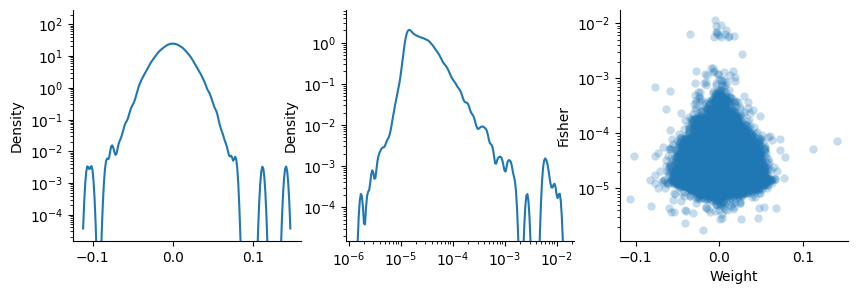

In [4]:
torch.manual_seed(100)
k = "model.layers.2.mlp.down_proj.weight"
n = int(2**16)

p = params[k]
f = fisher[k]
sample = torch.randperm(p.nelement())[:int(2**16)]
ps = p.flatten()[sample].float()
fs = f.flatten()[sample].float()

_, axs = plt.subplots(1, 3, figsize=(10, 3))
ax = sns.kdeplot(ps, ax=axs[0])
ax.set_yscale("log")
ax.set_ylim(1/len(ps), ax.get_ylim()[1])

ax = sns.kdeplot(fs, ax=axs[1], log_scale=True)
ax.set_yscale("log")
ax.set_ylim(1/len(fs), ax.get_ylim()[1])

ax = sns.scatterplot(x=ps, y=fs, lw=0, alpha=.25, ax=axs[2])
ax.set_yscale("log")
ax.set_xlabel("Weight")
ax.set_ylabel("Fisher")

## Sensitivity vs Value

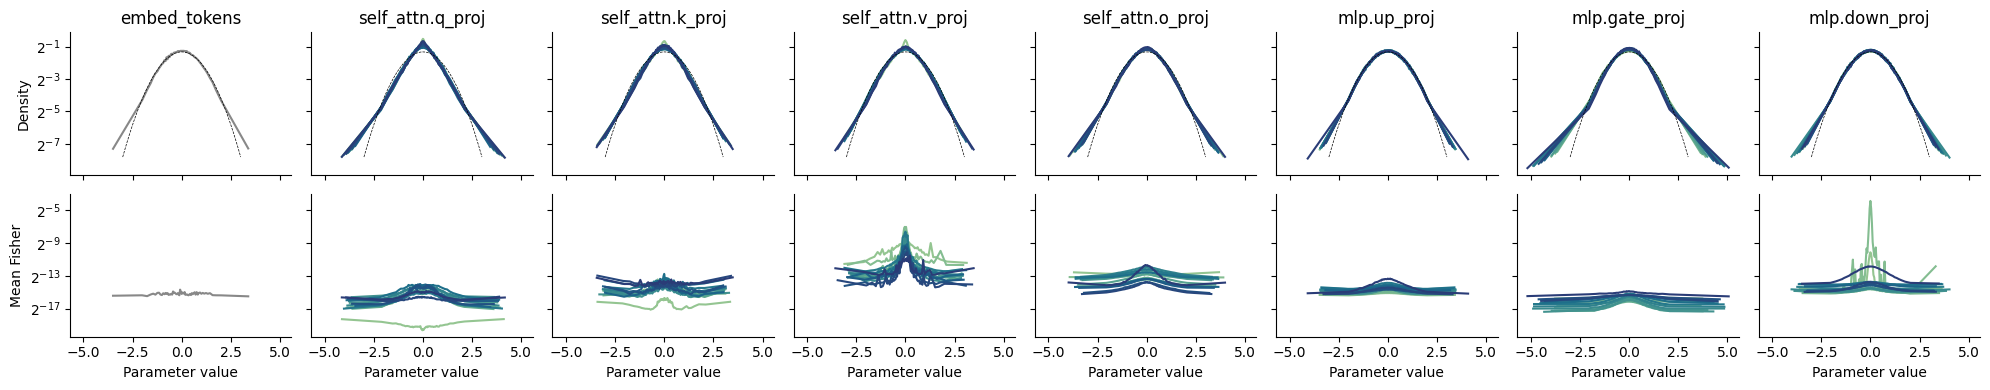

In [5]:
outliers = 1024
nbins = 64
maxn = int(2**24)
device = torch.device("cuda")
names = ["embed_tokens", "self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.o_proj", "mlp.up_proj", "mlp.gate_proj", "mlp.down_proj"]
_, axs = plt.subplots(nrows=2, ncols=len(names), figsize=(2.5*len(names), 2*2), sharey="row", sharex=True, squeeze=False)

palette = sns.color_palette("crest", n_colors=16)
for name, axc in zip(names, axs.T):
    if name == "embed_tokens":
        ks = [("model.embed_tokens.weight", "#888")]
    else:
        ks = [(f"model.layers.{i}.{name}.weight", palette[i]) for i in range(16)]
    for k, hue in ks:
        p, f = params[k].to(device), fisher[k].to(device)
        ps = p.flatten() / p.pow(2).mean().sqrt()
        fs = f.flatten()
        if len(ps) > maxn:
            idx = np.random.RandomState(100).choice(len(ps), maxn)
            ps, fs = ps[idx], fs[idx]
        ps, fs = ps.float(), fs.float()

        psort = torch.sort(ps)
        bine = psort.values[torch.linspace(outliers, len(ps) - 1 - outliers, nbins, device=ps.device).long()]
        binw = bine[1:] - bine[:-1]
        binc = (bine[1:] + bine[:-1]) / 2

        idx = torch.bucketize(ps, bine)

        bden = torch.bincount(idx, minlength=len(bine)+1)[1:-1] / binw / len(ps)
        bfmean = torch.scatter_reduce(torch.zeros(len(bine)+1, device=fs.device), 0, idx, fs, reduce="mean")[1:-1]
        bfmean2 = torch.scatter_reduce(torch.zeros(len(bine)+1, device=fs.device), 0, idx, fs.pow(2), reduce="mean")[1:-1]
        bfstd = (bfmean2 - bfmean**2).sqrt()

        for ax, y in zip(axc, [bden, bfmean, bfstd]):
            ax.plot(binc.cpu(), y.cpu(), color=hue)
        axc[0].set_title(name)

for ax in axs[0, :]:
    xs = torch.linspace(-3, 3, 1001)
    ax.plot(xs, scipy.stats.norm.pdf(xs), color="k", lw=0.5, ls="--")

for ax in axs.flatten():
    ax.set_yscale("log", base=2)
axs[0, 0].set_ylabel("Density")
axs[1, 0].set_ylabel("Mean Fisher")
for ax in axs[-1, :]:
    ax.set_xlabel("Parameter value")
axs[0, 0].figure.tight_layout()

## Structure

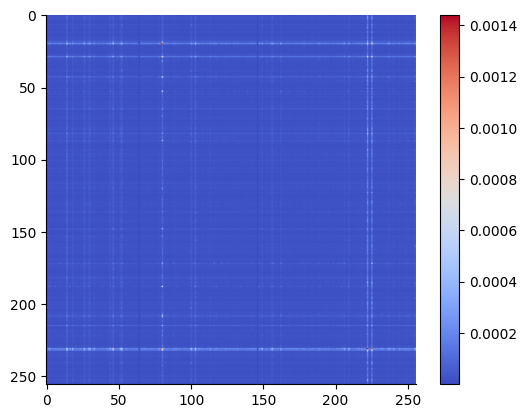

In [18]:
img = plt.imshow(fisher["model.layers.0.mlp.up_proj.weight"][:256, :256].float(), cmap="coolwarm")
plt.colorbar(img);